### Imports
Import the required libraries

#### real timeout with current
#### use json file for depth and current input
#### sailing on power with current not broken
#### sailing on power profile with current 

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.1,0.05],
    [0.2,0.1], 
    [0.3,0.15],
    [0.4,0.2],
    [0.5,0.25],
    [0.6,0.27],
    [0.7,0.25],
    [0.8,0.2],
    [0.9,0.15], 
    [1.0,0.1],
    [1.1,0.05],
    [1.2,0],

] 

# for each edge (between above coordinates) specify the depth (m)
depths = [18,18,18,18,18,18,18,18,18,18,18,18,]
current_speeds = [-0.5,-0.5,-0.5,-1,-1,-0.5,-0.5,-0.6,-0.7,-1,-0.5,-0.5] 
V_g_profile = [3,3,3,3,3,3,3,3,3,3,3,3]
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile": V_g_profile[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

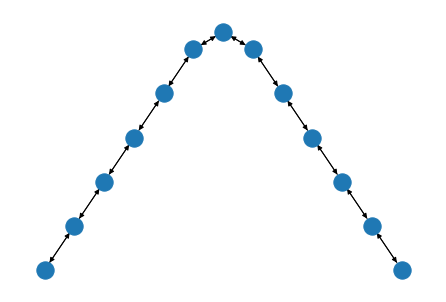

In [4]:
# show graph
nx.draw(FG, positions)
plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground Profile {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile"]))

General depth for edge ('Node 0', 'Node 1') is 18
Current speed for edge ('Node 0', 'Node 1') is -0.5
Vessel Speed To Ground Profile ('Node 0', 'Node 1') is 3
General depth for edge ('Node 1', 'Node 0') is 18
Current speed for edge ('Node 1', 'Node 0') is -0.5
Vessel Speed To Ground Profile ('Node 1', 'Node 0') is 3
General depth for edge ('Node 1', 'Node 2') is 18
Current speed for edge ('Node 1', 'Node 2') is -0.5
Vessel Speed To Ground Profile ('Node 1', 'Node 2') is 3
General depth for edge ('Node 2', 'Node 1') is 18
Current speed for edge ('Node 2', 'Node 1') is -0.5
Vessel Speed To Ground Profile ('Node 2', 'Node 1') is 3
General depth for edge ('Node 2', 'Node 3') is 18
Current speed for edge ('Node 2', 'Node 3') is -0.5
Vessel Speed To Ground Profile ('Node 2', 'Node 3') is 3
General depth for edge ('Node 3', 'Node 2') is 18
Current speed for edge ('Node 3', 'Node 2') is -0.5
Vessel Speed To Ground Profile ('Node 3', 'Node 2') is 3
General depth for edge ('Node 3', 'Node 4') is

### Create vessel - add VesselProperties and ConsumesEnergy mixins


In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

#### vessel_01  unloaded, upstream 

In [7]:
# Create a dict with all important settings

data_vessel_01 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 2,  # m/s
    "type": None,
    "B": 11.4,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":True, # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 2000, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "consider_passive_rudder_resistance": True,
    "consider_wind_influence": True,
    "U_wind": 2,# m/s
    "rel_winddir": 80,#degree
    "load": 'unloaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 2.5,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.9, 
    "C_year": 2000,
}             



#### vessel_02  loaded, downstream 

In [8]:
# Create a dict with all important settings

data_vessel_02 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 2,  # m/s
    "type": None,
    "B": 11.4,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 3,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":True, # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 2000, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "consider_passive_rudder_resistance": True,
    "consider_wind_influence": True,
    "U_wind": 2,# m/s
    "rel_winddir": 100,#degree
    "load": 'loaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 2.5,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.9, 
    "C_year": 2000,
}             



### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [9]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[12].name)
path_downstream = nx.dijkstra_path(FG, nodes[12].name, nodes[0].name)

### Define simulation

In [10]:
def run_simulation_01(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_01)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

In [11]:
def run_simulation_02(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_02)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### Run simulation


In [12]:
# create empty plot data

vessel_01 = run_simulation_01(V_g_ave = 2 , path = path_upstream)

# create an EnergyCalculation object and perform energy consumption calculation
energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel_01)
energycalculation.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation.energy_use)
df_upstream.head(15)


3.5 V_w
17.949414712646366
3.5 v4energy
28.293927765604643 R_wind
0.1414912244217491 R_rudder
3.5 V_w
17.949414712646366
3.5 v4energy
28.293927765604643 R_wind
0.1414912244217491 R_rudder
3.5 V_w
17.949414712646366
3.5 v4energy
28.293927765604643 R_wind
0.1414912244217491 R_rudder
4 V_w
17.933219837564483
4 v4energy
27.847651302424758 R_wind
0.18480486455085593 R_rudder
4 V_w
17.933219837564483
4 v4energy
27.847651302424758 R_wind
0.18480486455085593 R_rudder
3.5 V_w
17.949414712646366
3.5 v4energy
28.293927765604643 R_wind
0.1414912244217491 R_rudder
3.5 V_w
17.949414712646366
3.5 v4energy
28.293927765604643 R_wind
0.1414912244217491 R_rudder
3.6 V_w
17.946362084628287
3.6 v4energy
28.209432755242585 R_wind
0.14969194028619337 R_rudder
3.7 V_w
17.94321648466362
3.7 v4energy
28.122557603743566 R_wind
0.15812366223132612 R_rudder
4 V_w
17.933219837564483
4 v4energy
27.847651302424758 R_wind
0.18480486455085593 R_rudder
3.5 V_w
17.949414712646366
3.5 v4energy
28.293927765604643 R_wind
0.

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2022-12-01 10:18:27.000000,2022-12-01 12:02:01.638674,POINT (0 0),POINT (0.1 0.05),767.420013,767.420013,2000,2318.379629,511633.415532,5.627955e+05,...,2.634522e+07,20.848738,1.448987,1.622252e+06,720.911272,22299.624695,2318.379629,17.949415,12429.277348,6214.638674
1,2022-12-01 12:02:01.638674,2022-12-01 13:45:36.273596,POINT (0.1 0.05),POINT (0.2 0.1),767.420013,767.420013,2000,2318.378230,511633.106648,5.627951e+05,...,2.634521e+07,20.848725,1.448986,1.622251e+06,720.910837,22299.611233,2318.378230,17.949415,12429.269844,6214.634922
2,2022-12-01 13:45:36.273596,2022-12-01 15:29:10.901014,POINT (0.2 0.1),POINT (0.3 0.15),767.420013,767.420013,2000,2318.375430,511632.488879,5.627944e+05,...,2.634518e+07,20.848700,1.448985,1.622249e+06,720.909966,22299.584307,2318.375430,17.949415,12429.254836,6214.627418
3,2022-12-01 15:29:10.901014,2022-12-01 17:12:45.517175,POINT (0.3 0.15),POINT (0.4 0.2),1280.137987,1280.137987,2000,4419.759012,916910.702244,1.008599e+06,...,5.022453e+07,39.746034,2.762349,2.907278e+06,1315.301986,41130.277362,4419.759012,17.933220,12429.232323,6214.616161
4,2022-12-01 17:12:45.517175,2022-12-01 18:56:20.118329,POINT (0.4 0.2),POINT (0.5 0.25),1280.137987,1280.137987,2000,4419.748340,916908.488288,1.008597e+06,...,5.022441e+07,39.745938,2.762343,2.907271e+06,1315.298810,41130.178050,4419.748340,17.933220,12429.202307,6214.601154
5,2022-12-01 18:56:20.118329,2022-12-01 20:30:54.808289,POINT (0.5 0.25),POINT (0.6 0.27),767.420013,767.420013,2000,2116.951008,467180.983239,5.138979e+05,...,2.405626e+07,19.037329,1.323094,1.481306e+06,658.276076,20362.158285,2116.951008,17.949415,11349.379921,5674.689960
6,2022-12-01 20:30:54.808289,2022-12-01 22:05:29.498249,POINT (0.6 0.27),POINT (0.7 0.25),767.420013,767.420013,2000,2116.951008,467180.983239,5.138979e+05,...,2.405626e+07,19.037329,1.323094,1.481306e+06,658.276076,20362.158285,2116.951008,17.949415,11349.379921,5674.689960
7,2022-12-01 22:05:29.498249,2022-12-01 23:49:04.099403,POINT (0.7 0.25),POINT (0.8 0.2),861.576497,861.576497,2000,2677.177146,580479.908206,6.385264e+05,...,3.042247e+07,24.075334,1.673236,1.840546e+06,817.356667,25513.814358,2677.177146,17.946362,12429.202307,6214.601154
8,2022-12-01 23:49:04.099403,2022-12-02 01:32:38.715564,POINT (0.8 0.2),POINT (0.9 0.15),966.107157,966.107157,2000,3085.381257,659947.017120,7.259400e+05,...,3.506115e+07,27.746234,1.928363,2.092515e+06,934.870521,29100.881822,3085.381257,17.943216,12429.232323,6214.616161
9,2022-12-02 01:32:38.715564,2022-12-02 03:16:13.342982,POINT (0.9 0.15),POINT (1 0.1),1280.137987,1280.137987,2000,4419.767018,916912.363225,1.008601e+06,...,5.022463e+07,39.746106,2.762354,2.907283e+06,1315.304368,41130.351870,4419.767018,17.933220,12429.254836,6214.627418


In [13]:
vessel_02 = run_simulation_02(V_g_ave = 2 , path = path_downstream)

# create an EnergyCalculation object and perform energy consumption calculation
energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel_02)
energycalculation.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation.energy_use)
df_downstream

2.5 V_w
17.965109127723466
2.5 v4energy
-14.78962265072872 R_wind
0.07218940021517813 R_rudder
2.5 V_w
17.965109127723466
2.5 v4energy
-14.78962265072872 R_wind
0.07218940021517813 R_rudder
2 V_w
17.978064931249133
2 v4energy
-14.701668997777018 R_wind
0.04620121613771398 R_rudder
2.3 V_w
17.970664701759052
2.3 v4energy
-14.75209575880266 R_wind
0.061101108342126745 R_rudder
2.4 V_w
17.967949412720742
2.4 v4energy
-14.770468299641461 R_wind
0.06652975123830814 R_rudder
2.5 V_w
17.965109127723466
2.5 v4energy
-14.78962265072872 R_wind
0.07218940021517813 R_rudder


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



2.5 V_w
17.965109127723466
2.5 v4energy
-14.78962265072872 R_wind
0.07218940021517813 R_rudder
2 V_w
17.978064931249133
2 v4energy
-14.701668997777018 R_wind
0.04620121613771398 R_rudder
2 V_w
17.978064931249133
2 v4energy
-14.701668997777018 R_wind
0.04620121613771398 R_rudder
2.5 V_w
17.965109127723466
2.5 v4energy
-14.78962265072872 R_wind
0.07218940021517813 R_rudder
2.5 V_w
17.965109127723466
2.5 v4energy
-14.78962265072872 R_wind
0.07218940021517813 R_rudder
2.5 V_w
17.965109127723466
2.5 v4energy
-14.78962265072872 R_wind
0.07218940021517813 R_rudder


,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2022-12-01 10:18:27.000000,2022-12-01 12:02:01.638674,POINT (1.2 0),POINT (1.1 0.05),53.940059,53.940059,2000,116.395131,29826.252228,32808.801991,...,1.322672e+06,1.046719,0.072747,94571.043651,85.201236,2002.229037,116.395131,17.965109,12429.277348,6214.638674
1,2022-12-01 12:02:01.638674,2022-12-01 13:45:36.273596,POINT (1.1 0.05),POINT (1 0.1),53.940059,53.940059,2000,116.395060,29826.234222,32808.782184,...,1.322671e+06,1.046718,0.072747,94570.986557,85.201184,2002.227829,116.395060,17.965109,12429.269844,6214.634922
2,2022-12-01 13:45:36.273596,2022-12-01 15:29:10.901014,POINT (1 0.1),POINT (0.9 0.15),3.827543,3.827543,2000,6.607432,1693.154449,1862.465610,...,7.508445e+04,0.059419,0.004130,5368.538497,4.836640,113.661045,6.607432,17.978065,12429.254836,6214.627418
3,2022-12-01 15:29:10.901014,2022-12-01 17:12:45.517175,POINT (0.9 0.15),POINT (0.8 0.2),29.847609,29.847609,2000,59.254209,15183.890988,16702.241672,...,6.733433e+05,0.532862,0.037034,48144.044596,43.374081,1019.290899,59.254209,17.970665,12429.232323,6214.616161
4,2022-12-01 17:12:45.517175,2022-12-01 18:56:20.118329,POINT (0.8 0.2),POINT (0.7 0.25),41.182146,41.182146,2000,85.310203,21860.739642,24046.758299,...,9.694341e+05,0.767178,0.053319,69314.540330,62.447069,1467.506120,85.310203,17.967949,12429.202307,6214.601154
5,2022-12-01 18:56:20.118329,2022-12-01 20:30:54.808289,POINT (0.7 0.25),POINT (0.6 0.27),53.940059,53.940059,2000,106.282330,27234.847098,29958.262904,...,1.207754e+06,0.955776,0.066426,86354.393239,77.798666,1828.268643,106.282330,17.965109,11349.379921,5674.689960
6,2022-12-01 20:30:54.808289,2022-12-01 22:05:29.498249,POINT (0.6 0.27),POINT (0.5 0.25),53.940059,53.940059,2000,106.282330,27234.847098,29958.262904,...,1.207754e+06,0.955776,0.066426,86354.393239,77.798666,1828.268643,106.282330,17.965109,11349.379921,5674.689960
7,2022-12-01 22:05:29.498249,2022-12-01 23:49:04.099403,POINT (0.5 0.25),POINT (0.4 0.2),3.827543,3.827543,2000,6.607404,1693.147294,1862.457739,...,7.508414e+04,0.059419,0.004130,5368.515809,4.836620,113.660565,6.607404,17.978065,12429.202307,6214.601154
8,2022-12-01 23:49:04.099403,2022-12-02 01:32:38.715564,POINT (0.4 0.2),POINT (0.3 0.15),3.827543,3.827543,2000,6.607420,1693.151382,1862.462236,...,7.508432e+04,0.059419,0.004130,5368.528772,4.836631,113.660839,6.607420,17.978065,12429.232323,6214.616161
9,2022-12-02 01:32:38.715564,2022-12-02 03:16:13.342982,POINT (0.3 0.15),POINT (0.2 0.1),53.940059,53.940059,2000,116.394920,29826.198208,32808.742569,...,1.322670e+06,1.046717,0.072747,94570.872367,85.201081,2002.225411,116.394920,17.965109,12429.254836,6214.627418


In [14]:
from opentnsim.energy import ConsumesEnergy

In [15]:
test = ConsumesEnergy.calculate_angle(vessel_01,v=2)
test

(1,
 65959.34577252953,
 178663.44823812388,
 0.04620121613771398,
 4975636.253862317)